
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 1 - Ejercicio 2

### Integrantes
- Bosch, Daniela
- Gherra, Estefanía
- Iberra, Yanina
- Mantovani, Luciano
- Palacio Pastor, Natalí

## **Resumen**

El presente trabajo contiene la resolución de dos ejercicios, con varios análisis dentro de cada uno de ellos, organizados tal como se detalla a continuación.

El primero se estructura partiendo del "interrogante general de investigación", y se ofrece un desarrollo que responde a las consignas propuestas, pretendiendo ir de lo general a lo particular, y obtener información que nos permita responder la pregunta a cada paso.

El segundo mantiene fielmente la estructuración propuesta en las consignas, desagregando en sub-ítems los aspectos a destacar según las herramientas seleccionadas para resolverlas.

### Librerías y configuraciones generales

In [1]:
import io
import scipy
import matplotlib
import numpy
import pandas as pd
import seaborn

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
seaborn.set_context('talk')

# Set float format
pd.set_option('display.float_format','{:.2f}'.format)

# Set style
seaborn.set_style("darkgrid")
seaborn.set_palette('pastel') 
seaborn.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})

pd.options.mode.chained_assignment = None 

### Funciones auxiliares

In [2]:
def remove_outlier(df_in, col_name, iqr_factor = 1.5):
    """
    IQR outliers removal 
    (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
    accept a dataframe, remove outliers, return cleaned data in a new dataframe
    see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
    """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 # interquartile range
    fence_low  = q1 - iqr_factor*iqr
    fence_high = q3 + iqr_factor*iqr
    df_inliers = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    df_outliers = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    return df_inliers, df_outliers

### Lectura del dataset y definiciones previas

In [3]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
raw_df = pd.read_csv(url)

In [4]:
# Salario Mínimo en Argentina de Octubre 2019 a Octubre del 2020 (la encuesta es de Julio/Agosto 2020). 
# Ver detalles y referencia en la sección "2.1 Eliminación de outliers"
MIN_WAGE = float(16875)

# Frecuencia default para visualizaciones
FREQ = 10

**Código para poder abrir el archivo con el dataset "depurado en el Entregable 1 - Ejercicio 1", desde el drive compartido. Seguir los pasos que indica:**

In [5]:
# Al ejecutar el código, se mostrará un link, al cual se debe acceder 
# con la cuenta de correo (personal) autorizada en el drive compartido

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(filename)

drive = connect_to_drive()
df = read_csv_from_drive(drive, '10-5Uh0QCwrXY6HqbOGVsFQzIIAM7xCPd' , 'dataset_without_outliers.csv')

**ACLARACIÓN: Para los siguientes análisis no se utilizará el dataframe convertido a One Hot encoding (df), si no que se trabajará con la función propuesta en clase (filtered_df_lang).**

Las siguientes celdas de código separan estos lenguajes de programación.

In [6]:
relevant_columns = [
    'tools_programming_languages', 
    'salary_monthly_NETO', 
    'salary_monthly_BRUTO',
    'tools_work_pc_os',
    'work_contract_type',
    'tools_frameworks',
    'profile_years_experience',
    'salary_satisfaction',
    'company_main_activity',
    'salary_in_usd',
    'work_role',
    'work_years_in_company',
    'profile_gender',
    'profile_age',
    'profile_studies_level'
]
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]
  #return [lang.strip()
  #        for lang in languages_str.split(',')]

# Create a new column with the list of languages
df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.

# Frecuencia de lenguajes para quedarnos con los de freq. > 10
language_count = df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})
df_lang['frequency_programming_language'] = df_lang \
  .groupby('programming_language')['programming_language'] \
  .transform('count')
df_lang['normalized_frequency_programming_language'] = df_lang \
  .groupby('programming_language')['programming_language'] \
  .transform('count') / len(df_lang)
# Nos quedamos con los lenguajes con freq. > 10
interesting_languages = language_count[language_count['frequency'] > 10]['language']
filtered_df_lang = df_lang[df_lang.programming_language.isin(interesting_languages)]
# Eliminamos los casos 'ninguno'
filtered_df_lang = filtered_df_lang[~filtered_df_lang.programming_language.isin(['ninguno'])]
filtered_df_lang.programming_language.nunique() # Verificamos que tiene 35 lenguajes, igual que el df one_hot

#Creamos una variable categórica "salary_is_usd_cat", que refleja si los salarios están dolarizados o no 
df['salary_is_usd_cat'] = df.salary_in_usd
# Reemplazamos los valores na de la columna salary_in_usd
df['salary_is_usd_cat'].fillna('Mi sueldo es en pesos', inplace=True)

# Ejercicio 2: Densidades y varias variables

Responder a la pregunta general: **¿Qué herramientas (prácticas y teóricas) són útiles para explorar la base, descubrir patrones, asociaciones?**

Para ello considere (igual al ejercicio Anterior):
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en sub-poblaciones. 

A lo largo de los diferentes ejercicios y entregables, hemos utilizado diferentes herramientas para explorar la base de datos, descubrir patrones y asociaciones.

- Como una primera manera de familiarizarse con el dataset e ir teniendo algo de información al respecto, utilizamos **estadística descriptiva**, como el método `.describe()`.
Este método nos brinda diferentes estadísticos importantes para cada columna del dataset: 

  *   `count`: cantidad de datos
  *   `mean` : media de la columna
  *   `std`: varianza de la columna
  *   `min` y `max` : valores  mínimos y máximos
  *   valores de percentiles del `25%`, `50%` y `75%`.

  La información brindada permite detectar valores "extraños" u "outliers", como en el caso de la variable `profile_age` de la sección 1, que presentaba una media es 45,6 años, pero una varianza de ¡665.72 años! Lo cual es extraño. Si vemos el valor máximo, es de 52mil años.

  También permite identificar valores faltantes para luego utilizar diferentes métodos para computarlos o eliminarlos.

  El método `.info()` nos brinda información para empezar a interpretar el tipo de cada variable: si es numérica o categórica (aunque hay excepciones, por ejemplo la satisfación con tu salario `salary_satisfaction`, son números, pero corresponden a una escala de más a menos satisfacción).

- Otra herramienta útil es la **visualización** mediante diferentes gráficos. Por ejemplo un boxplot nos permite identificar y comparar la mediana en variables numéricas siendo posible utilizarlo con grupos categóricos. Podemos ver las frecuencias mediante gráficos de barra y distribuciones mediante histogramas. En el cso de variables numéricas continuas los scatterplots, nos ayudan a encontrar la presencia o ausencia de correlaciones entre ellas.

 

## a) Densidad conjunta

**¿Qué herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos?**

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. ¿Puede describir de alguna forma el comportamiento de sus datos? ¿Qué herramientas utilizaría? Describa.




**Variables numéricas**
*   `profile_age`
*   `profile_years_experience`
*   `salary_monthly_NETO`

**Variables categóricas**
*   `salary_is_usd_cat`
*   `work_contract_type`



#### **Analizamos una variable numérica (salario neto) y una categórica (¿salario dolarizado?)**

`salary_monthly_NETO` vs. `salary_is_usd_cat`

- Con una variable categórica y una numérica podemos estudiar su distribución "conjunta" mediante un **histograma**, que diferencie por colores las distintas categorías. Sin embargo, para tener mayor claridad, es recomendable observar también la distribución de la variable numérica, para cada categoría ("o sea, condicionada por categoría"), mediante los gráficos **boxplot**. Se muestra todo esto en los gráficos de abajo.

- **Notar**: Elegimos estas dos variables porque creemos (y ya vimos de hecho en el punto 2.2) que la distribución de los salarios en pesos se va a diferenciar de la distribución de salarios en dólares (siendo los valores de esta última superiores a los de la primera).

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800., 900.]),
 <a list of 10 Text major ticklabel objects>)

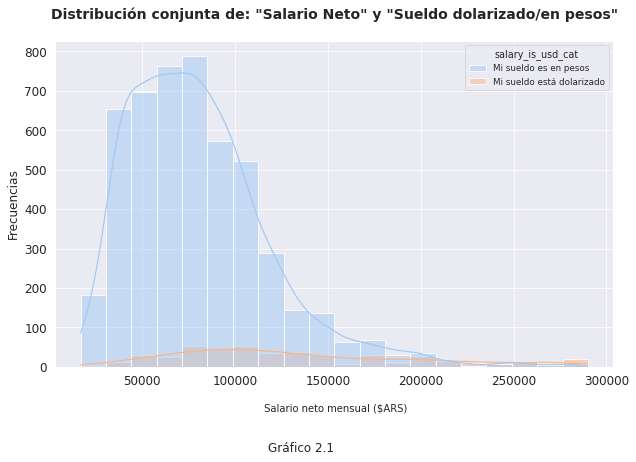

In [7]:
# Histograma distribución conjunta salario neto y ¿es dolar?
plt.figure(figsize=(10, 6))
seaborn.histplot(data=df, x="salary_monthly_NETO", hue="salary_is_usd_cat", kde=True, bins=20)

#plt.ticklabel_format(style='plain', axis='x')
plt.title('Distribución conjunta de: "Salario Neto" y "Sueldo dolarizado/en pesos"\n', fontsize=14, weight='bold')
plt.ylabel("Frecuencias")
plt.xlabel("\n Salario neto mensual ($ARS)", fontsize=10)
plt.annotate(
    'Gráfico 2.1', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

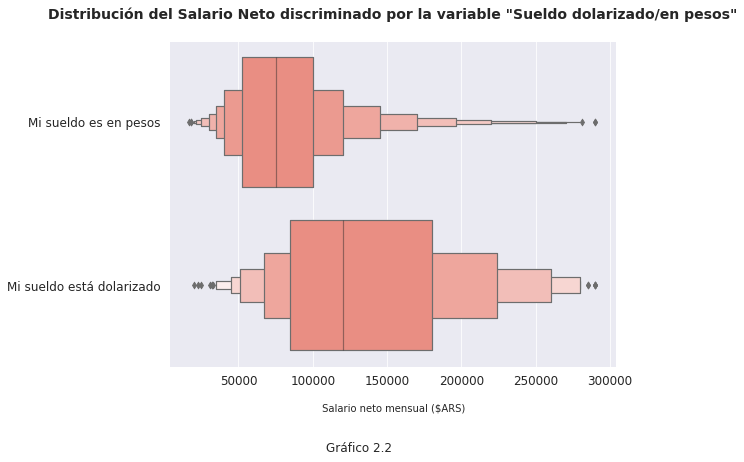

In [8]:
# Distribución del salario neto, según si el ingreso está dolarizado o no.
fig = plt.figure(figsize=(8, 6))
g = seaborn.boxenplot(
    data=df, 
    x='salary_monthly_NETO',
    y='salary_is_usd_cat', 
    color='salmon'
)
#plt.ticklabel_format(style='plain', axis='x')
plt.title('Distribución del Salario Neto discriminado por la variable "Sueldo dolarizado/en pesos"\n', fontsize=14, weight='bold')
plt.ylabel("")
plt.xlabel("\n Salario neto mensual ($ARS)", fontsize=10)
plt.annotate(
    'Gráfico 2.2', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

**Observaciones**:

- Tal como ya se explicó en la sección 2.2, al analizar los salarios netos diferenciados por la variable 'salary_is_usd_cat', se encuentran dos subpoblaciones diferentes.

- En el gráfico 2.1 se observa que los salarios en dólares son menos frecuentes que los en pesos, y además, que la distribución de los en dólares, llegan a valores mayores que los en pesos.

- En el gráfico 2.2 se observa con mayor claridad que los sueldos dolarizados tienen una mediana mayor que los sueldos en pesos, y que también muestran mayor variabilidad en el 50% central de sus datos (rango intercuartílico).

#### **Analizamos dos variables categóricas (Salario en dólares y Tipo de contrato)**

`salary_is_usd_cat` vs. `work_contract_type`

- Para trabajar con dos variables categóricas, utilizamos el **heatmap**.

- Elegimos estas dos variables porque creemos que hay cierta relación entre el tipo de contrato y que se cobre o no el salario en dólares. 

- En particular, creemos que los "Freelance" y/o los "Remotos" se asocian más a sueldos en dólares que el resto de las categorías de contratación.

- Primero vamos a mostrar el heatmap que muestra la distribución de ambas variables en forma conjunta, y luego mostraremos heatmaps que muesrtan básicamente las tablas de contingencia que totalizan valores por columna, o por fila, para observar la posible relación mencionada.


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

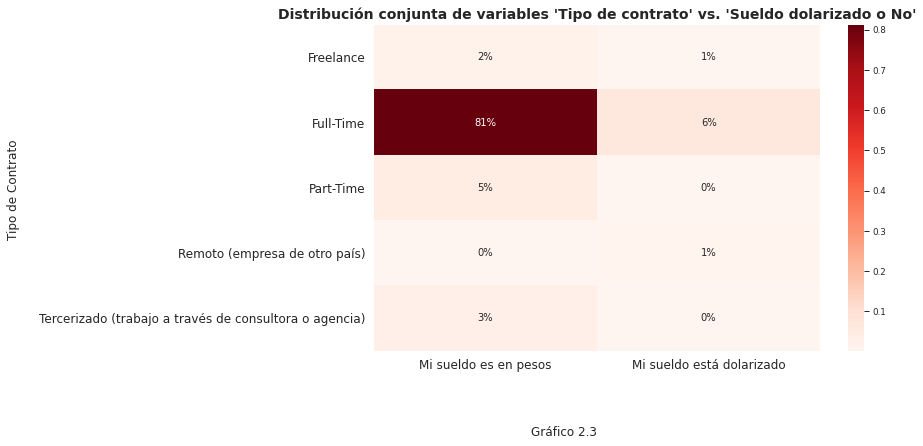

In [9]:
fig = plt.figure(figsize=(10,6))
exp = pd.crosstab(
    df['work_contract_type'],
    df['salary_is_usd_cat'],
    normalize='all'
)
seaborn.heatmap(exp, annot=True, fmt='0.0%', cmap='Reds') #Greys
plt.xlabel("")
plt.ylabel("Tipo de Contrato \n")
plt.title("Distribución conjunta de variables 'Tipo de contrato' vs. 'Sueldo dolarizado o No'", fontsize=14, weight='bold')
plt.annotate(
    'Gráfico 2.3', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

**Observaciones**

- En este heatmap, se observa la distribución conjunta de frecuencias relativas para las variables en cuestión, utilizando la intensidad y oscuridad del color para representar el "ordenamiento" de los valores de menor a mayor.

- Como se apreciar a simple vista, la mayoría de los encuestados (el 81%) del total general, tienen contrato Full-Time y cobran su sueldo en pesos.

- Entre los valores con menor concentración de personas vemos: 
  - Que un 6% del total, tienen un contrato Full-Time y su sueldo está dolarizado.
  - Un 5% del total son Part-Time y su sueldo está en pesos.
  - Un 3% del total están Tercerizados y cobran en pesos.
  - Las demás cifras se pueden observar en el gráfico, aclarando que los valores que figuran con 0% en realidad tiene números después de la coma, pero figuran con cero por ser muy baja proporción en relación al total general.



Agregamos los dos heatmap a continuación, para ver posibles relaciones entre las variables. 

Veamos primero cómo se distribuyen los porcentajes en columna: sueldos en Pesos (100%) según tipo de contrato, y sueldos en Dólares (100%), según el tipo de contrato:

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

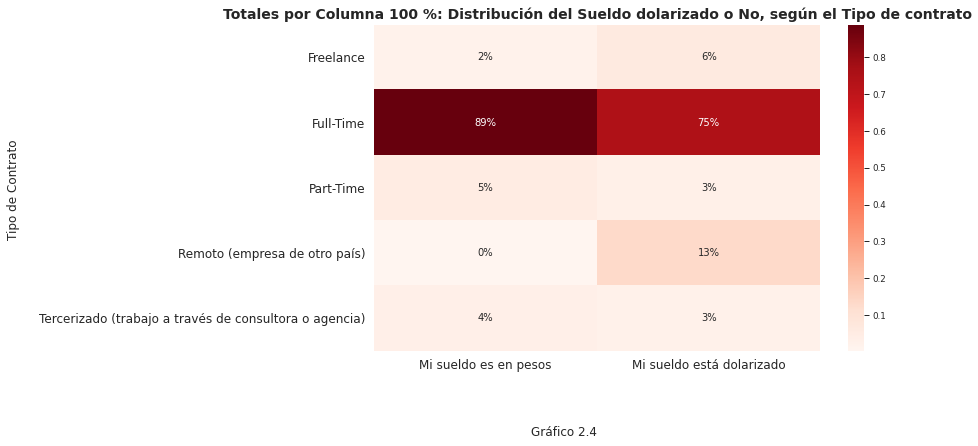

In [10]:
fig = plt.figure(figsize=(10,6))
exp = pd.crosstab(
    df['work_contract_type'],
    df['salary_is_usd_cat'],
    normalize='columns'
)
seaborn.heatmap(exp, annot=True, fmt='0.0%', cmap='Reds')
plt.xlabel("")
plt.ylabel("Tipo de Contrato \n")
plt.title("Totales por Columna 100 %: Distribución del Sueldo dolarizado o No, según el Tipo de contrato", fontsize=14, weight='bold')
plt.annotate(
    'Gráfico 2.4', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

**Observaciones**:

- En el heatmap de arriba se observa que si bien hay una mayor concentración de casos en el tipo de contrato "Full-Time" tanto para sueldos en pesos como para sueldos en dólares (color intenso), lo que se puede apreciar viendo las cifras porcentuales, es que para el caso de los contratos "Full-Time", "Part-Time" y "Tercerizado", la proporción de personas que cobran en pesos, es mayor a la de los que cobran en dólares.

- Mientras que en los contratos "Remoto" y "Freelance", el comportamiento se invierte: es mayor la proporción de personas que cobran en dólares respecto a la de los que cobran en pesos.

- Esto da señales de la existencia de asociación entre esas categorías de las variables.


Vemos ahora la distribución por filas, es decir, para cada tipo de  contrato cómo se distribuyen los salarios en dólares y en pesos.

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

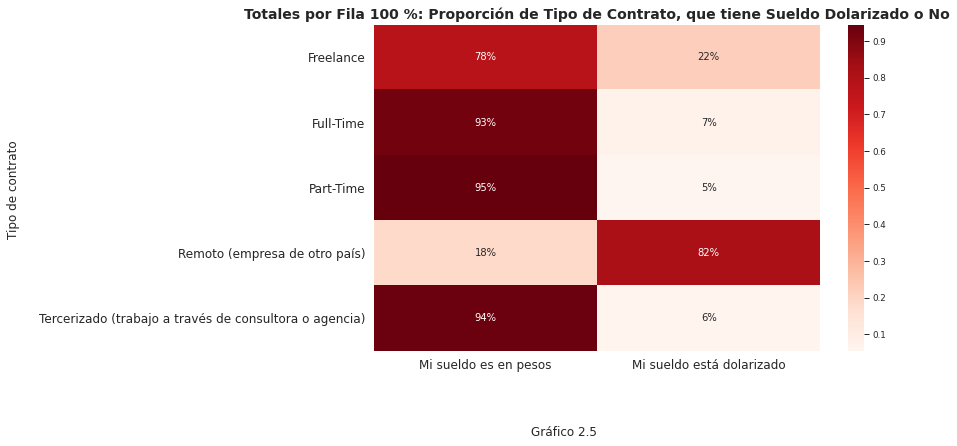

In [11]:
fig = plt.figure(figsize=(10,6))
exp = pd.crosstab(
    df['work_contract_type'],
    df['salary_is_usd_cat'],
    normalize='index'
)
seaborn.heatmap(exp, annot=True, fmt='0.0%', cmap='Reds')
plt.xlabel("")
plt.ylabel("Tipo de contrato \n")
plt.title("Totales por Fila 100 %: Proporción de Tipo de Contrato, que tiene Sueldo Dolarizado o No", fontsize=14, weight='bold')
plt.annotate(
    'Gráfico 2.5', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

**Observaciones**:

- Al mostrar los porcentajes en fila, resalta a la vista la situación de los contratos remoto. Del 100% de este tipo de contratos, el 82% tiene sueldos dolarizados.

- En el caso de los freelance, si bien no se ve un comportamiento tan marcado como en el remoto en donde la mayoría cobra en dólares; se aprecia que el porcentaje de este tipo de contrato dolarizado (21%) es mayor que los porcentajes respectivos de contratos "Full-Time", "Part-Time" y "Tercerizado" (7%, 5% y 6% respectivamente).

- En pocas palabras, los datos van en el sentido de la creencia que postulamos (que la distribución de salarios en dólares es superio a la de los salarios en pesos).

#### **Analizamos dos variables numéricas (edad de la persona, y años de experiencia)**
`profile_age` vs `profile_years_experience`. 
Comparamos 2 variables numéricas.

- Cuando trabajamos con dos variables numéricas a la vez (análisis bivariado), utilizamos el **jointplot** para ver la densidad conjunta de ambas variables en "3D" (observando que a mayor intensidad de color, mayor frecuencia)  y el **scatrerplot** para ver la distribución de cada par de puntos u observaciones en "2D", y su posible relación. Las estadísticas descriptivas como media, mediana, cuartiles, min y máx nos permiten caracterizar la distribución con mayor rigurosidad.

- De acuerdo a las variables escogidas, lo que esperamos observar es una relación positiva (lineal) entre los años de experiencia de una persona encuestada, y la edad que esa persona tiene.

Descriptivas de Años de experiencia laboral:  count   5457.00
mean       8.80
std        7.02
min        0.00
25%        3.00
50%        7.00
75%       13.00
max       44.00
Name: profile_years_experience, dtype: float64


Descriptivas de Edad:  count   5457.00
mean      32.52
std        7.26
min       18.00
25%       27.00
50%       31.00
75%       37.00
max       67.00
Name: profile_age, dtype: float64


Text(-2.5, -0.2, 'Gráfico 2.6')

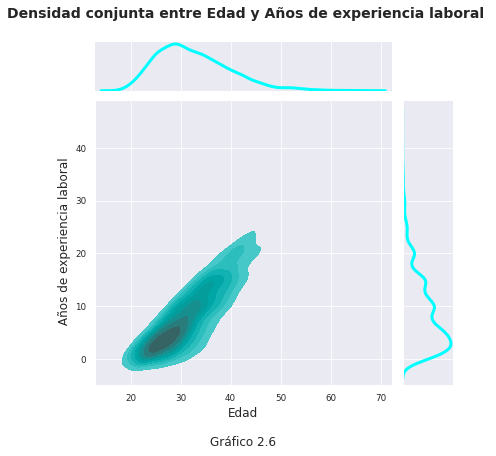

In [12]:
# Descriptiva de profile_years_experience y profile_age, decidir la eliminación de extremos y graficar lo razonable empíricamente
#  (se omite impresión, pero puede observarse quitando los #)
#print(df['profile_years_experience'].describe())
#print(df['profile_age'].describe())


# Descriptiva de profile_years_experience y profile_age,  post eliminación de extremos no razonables
df_temp = df.query( 'profile_years_experience < 90 & profile_age < 100')
print( "Descriptivas de Años de experiencia laboral: ", df_temp['profile_years_experience'].describe())
print("\n")
print("Descriptivas de Edad: " , df_temp['profile_age'].describe())

# Gráfico de densidad conjunta entre profile_age y profile_years_experience (simula el efecto "3D" mediante la intensidad del color)
p = seaborn.jointplot(data=df.query( 'profile_years_experience < 50 & profile_age < 70'), # notar: se eliminan extremos no razonables empíricamente.
        x='profile_age', y='profile_years_experience', kind='kde', joint_kws=dict(fill=True, color='cyan'), 
              marginal_kws=dict(color='cyan', fill=False, linewidth=3), height=6)
p.ax_joint.set_ylabel('\n Años de experiencia laboral')
p.ax_joint.set_xlabel('Edad')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
p.fig.suptitle("Densidad conjunta entre Edad y Años de experiencia laboral \n", fontsize=14, weight='bold')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.9) # Reduce plot to make room 
plt.annotate('Gráfico 2.6', xy=(-2.5, -0.2), xycoords='axes fraction', ha='right', va='center', fontsize=12)



**Observaciones:**

- En el Gráfico 2.6 vemos la densidad conjunta y las densidades marginales de Edad y Años de experiencia laboral.

- Se aprecia que ambas distribuciones son asimétricas hacia la derecha, concentrando sus valores en los valores inferiores de la distribución.

- Para contar con mayor rigurosidad en estras cifras se calcularon las estadísticas descriptivas, donde se ve que el 50% central de los datos se concentran entre los 3 y 13 años de experiencia laboral; y entre los 27 y 37 años de edad (zona de color más intensa en el gráfico 2.6).

- Se visualiza también en este gráfico y en el gráfico 2.7 siguiente (scatterplot) la relación lineal positiva entre ambas variables (tal como esperábamos observar).

Text(0.5, -0.15, 'Gráfico 2.7')

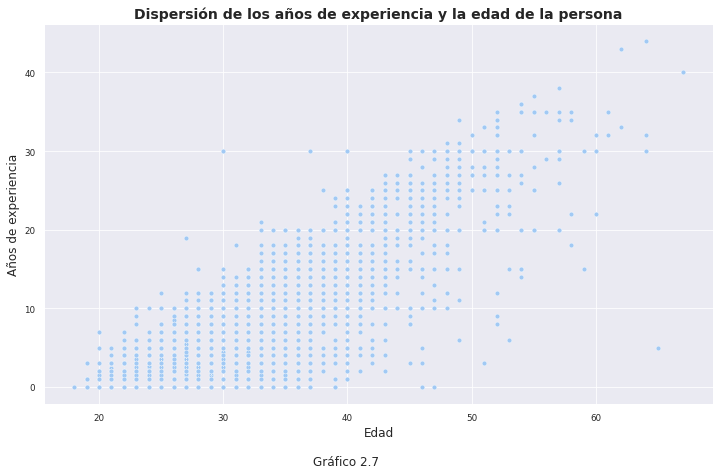

In [13]:
fig = plt.figure(figsize=(12, 7))
seaborn.scatterplot(
    data=df[(df['profile_age'] < 100) & (df['profile_years_experience'] < 90)], 
    x='profile_age', 
    y='profile_years_experience'
).set_title('Dispersión de los años de experiencia y la edad de la persona', fontsize=14, weight='bold')
plt.xlabel("Edad")
plt.ylabel("Años de experiencia")

plt.annotate(
    'Gráfico 2.7', 
    xy=(0.5, -0.15), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)

## b) Asociación

* **Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el neto? ¿Qué abordaje y medidas usaría?**



`salary_monthly_NETO` vs. `salary_monthly_BRUTO`

### Visualización

- Tal como explicamos para el caso de dos variables numéricas, visualizamos primero la distribución conjunta de ellas a través de un scatterplot.

- Utilizamos los datos de salario ya "curados".

Text(0.5, -0.25, 'Gráfico 2.8')

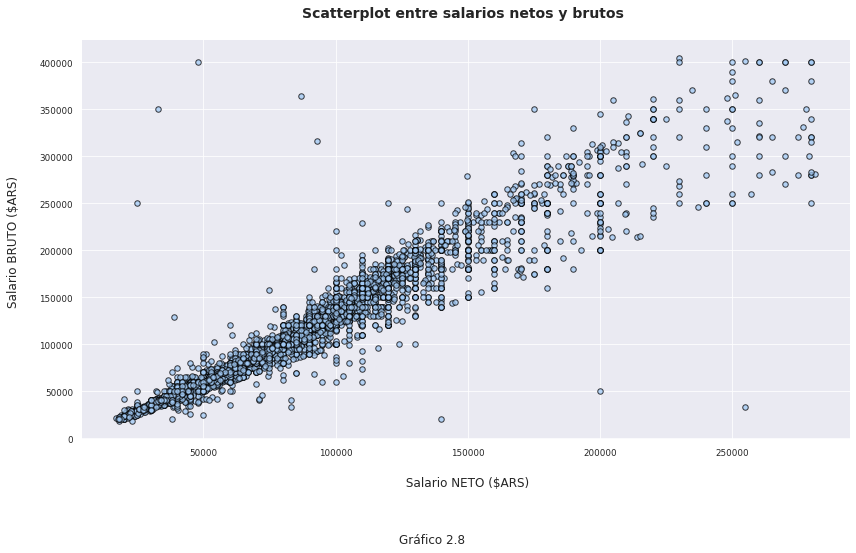

In [14]:
df_in_bruto, df_out_bruto = remove_outlier(df, 'salary_monthly_BRUTO', 3.5)
df_in_neto, df_out_neto = remove_outlier(df, 'salary_monthly_NETO', 3.5)

df_in_neto = df_in_neto.query('salary_monthly_NETO >= @MIN_WAGE')
df_in_bruto = df_in_bruto.query('salary_monthly_BRUTO >= @MIN_WAGE')

df['cured_salary_neto'] = df_in_neto['salary_monthly_NETO']
df['cured_salary_bruto'] = df_in_bruto['salary_monthly_BRUTO']

x = df["cured_salary_neto"]
y = df["cured_salary_bruto"]

fig = plt.figure(figsize=(12, 7))
plt.scatter(x,y, s=30, cmap="summer", edgecolor='black', linewidth=1, alpha=0.75)
plt.title("Scatterplot entre salarios netos y brutos \n", fontsize=14, weight='bold')
plt.xlabel("\n Salario NETO ($ARS)")
plt.ylabel("Salario BRUTO ($ARS) \n")
plt.tight_layout()
plt.annotate(
    'Gráfico 2.8', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)

**Observaciones**:

- Si bien algunos outliers persisten a la curación, con la limpieza de outliers se quitaron muchos datos que podrían ser cargados por error o que denotaban situaciones poco reales (fundamentalmente los valores nulos, $0, o muy bajos, que vimos en el análisis realizado en forma detallada para estas dos variables de sueldo, en el notebook entregado previamente con el nombre "AyVd - Grupo Palas Atenea - Ejercicios").

- El gráfico de dispersión entre el Salario Bruto y Neto que mostramos arriba (Gráfico 2.8 - Scatterplot) nos da la pauta de que existe una relación lineal positiva entre las variables, y que por lo tanto no son independientes.

### Métricas

Las variables NO son estadísticamente independientes (o sea, sí hay asociación entre ellas) cuando: 
- $Cov(X,Y)\neq0$
- $Corr(X,Y)\neq0$
- $Var(X+Y) \neq Var(X)+Var(Y)$
- $E(X.Y) \neq E(X).E(Y)$


Calculemos estos valores para concluir independencia o no entre las variables:


**Covarianza y correlación**

- $Cov(X,Y) = {\Sigma{(X-μ_X)(Y-μ_Y)}\over{N-1}}$,  para  $μ_X = E(X)$ y $μ_Y = E(Y)$

- $Corr(X,Y) = {{Cov(X,Y)}\over{\sigma_1 \sigma_2}}$, para ${σ_1}^2 = Var(X)$ y ${σ_2}^2 = Var(Y)$


In [15]:
# Covarianza
cov_df = df[['salary_monthly_NETO', 'salary_monthly_BRUTO']].cov()
cov = cov_df['salary_monthly_NETO']['salary_monthly_BRUTO']
print("La convarianza entre ambas variables es:", cov)

La convarianza entre ambas variables es: 2820489025.899762


In [16]:
# Correlación
corr_df = df[['salary_monthly_NETO', 'salary_monthly_BRUTO']].corr(method="spearman")
corr = corr_df['salary_monthly_NETO']['salary_monthly_BRUTO']
print("La correlación entre ambas variables es:", corr)

La correlación entre ambas variables es: 0.9600374465996055


- Para calcular la correlación utilizamos el método de Spearman ya que nuestra distribución no es normal. 
- Como el coeficiente de correlación es positivo y próximo a 1 (0,96), podemos concluir que existe una alta correlación entre Salario Bruto y Salario Neto, y que esta relación es lineal y positiva.

**Varianza**

- $Var(X+Y) \neq Var(X)+Var(Y)$

In [17]:
# Varianza del salario neto
X_var = df['salary_monthly_NETO'].var()

# Varianza del salario bruto
Y_var = df['salary_monthly_BRUTO'].var()

# Varianza conjunta
XY_var = (df['salary_monthly_NETO'] + df['salary_monthly_BRUTO']).var()

# Suma de las varianzas
sum_var = X_var + Y_var

print("Varianza conjunta:", XY_var) 
print("Suma de las varianzas: ", sum_var)

Varianza conjunta: 14531920805.20794
Suma de las varianzas:  8890942753.408415


Se puede concluir en base a los calculos y las condiciones definidas, que no son independientes





**Esperanza de ambas variables y la esperanza conjunta**
- $E(X)$
- $E(Y)$
- $E(X.Y)$
- $E(X).E(Y)$

In [18]:
# Esperanza del salario neto
X_mean = df['salary_monthly_NETO'].mean()

# Esperanza del salario bruto
Y_mean = df['salary_monthly_BRUTO'].mean()

# Esperanza conjunta
XY_mean = (df['salary_monthly_NETO'] * df['salary_monthly_BRUTO']).mean()

# Multiplicación de esperanzas
mult_means = X_mean * Y_mean

print("La esperanza conjunta es de:", XY_mean)
print("La multiplicación de las esperanzas es:", mult_means)

La esperanza conjunta es de: 12373702515.739206
La multiplicación de las esperanzas es: 9553730062.921112


Se puede ver en los cálculos que son distintas.

**En resumen  vemos en nuestros datos que se cumple:**

- $Cov(X,Y)\neq0$

  > en los datos $Cov(X,Y) = 2820489025.89$

- $Corr(X,Y)\neq0$

  > en los datos $Cov(X,Y) = 0.96$


- $Var(X+Y) \neq Var(X)+Var(Y)$

  > en los datos $14531920805.20794 \neq 8890942753.408415$


- $E(X.Y) \neq E(X).E(Y)$
  
  > en los datos $12373702515.739206 \neq 9553730062.921112$

Por lo que concluimos que las variables `salary_monthly_NETO` y `salary_monthly_BRUTO` no son estadísticamente independientes (o sí tienen asociación).

Ahora calculamos el coeficiente de variación para decidir con qué variable nos quedamos:

**Coeficiente de variación**

In [19]:
# Coeficiente de variación
X_coef_var = df['salary_monthly_NETO'].std() / df['salary_monthly_NETO'].mean()
Y_coef_var = df['salary_monthly_BRUTO'].std() / df['salary_monthly_BRUTO'].mean()
print("coef. de var. de Salario Neto:", X_coef_var)
print("coef. de var. de Salario Bruto:", Y_coef_var)

coef. de var. de Salario Neto: 0.5204374680739952
coef. de var. de Salario Bruto: 0.7438223391458495


- Una información importante a considerar cuando tenemos que esoger entre dos variables que están asociadas entre sí, es el coeficiente de variación de cada una de ellas. Ya que mientras menor sea el CV, menor dispersión tendrá la variable en relación a su media, y por lo tanto más representativa será dicha de su distribuición.

- En este caso, si tenemos que elelgir entre salario bruto y neto observando el CV (0,52 vs. 0,74 respectivamente), eligiríamos el Salario Neto por tener sus valores menor variabilidad alrededor de su media.

**Notar:** Porcentaje de datos nulos de las variables en el dataset original.

In [20]:
# salary_monthly_NETO
print("Cantidad de valores nulos en la variable salary_monthly_NETO: {}".format(
    len(raw_df[raw_df['salary_monthly_NETO'].isnull()]) / len(raw_df) * 100 ), "\n")

# salary_monthly_BRUTO
print("Cantidad de valores nulos en la variable salary_monthly_BRUTO: {}".format(
    len(raw_df[raw_df['salary_monthly_BRUTO'].isnull()]) / len(raw_df) * 100 ), "\n")

Cantidad de valores nulos en la variable salary_monthly_NETO: 3.4782608695652173 

Cantidad de valores nulos en la variable salary_monthly_BRUTO: 0.0 



**Conclusión de la elección entre `salary_monthly_NETO` vs. `salary_monthly_BRUTO` :**

- Como vimos anteriormente los datos nulos de la variable `salary_monthly_NETO` representan un 3,47% del total. Consideramos que es un porcentaje bajo y no afectará al análisis.

- Nos conviene trabajar con una sola variable ya que ambas están fuertemente correlacionadas (ver coeficiente de correlación entre salario neto y bruto igual a 0,96). 

- Decidimos utilizar la variable `salary_monthly_NETO` ya que tiene un coeficiente de variación menor al del salario bruto, lo que implica menor variación de los datos en torno a su media.

## c) Densidad condicional 

**Estudie la distribución del salario según el nivel de estudio.**

**Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`**

**¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?**

**Calcule medidas de centralización y dispersión para cada subpoblación.**






### Salario neto según nivel de estudio "Terciario" y "Universitario".

In [21]:
# Vemos la cantidad de ocurrencias por cada nivel de estudio.
df['profile_studies_level'].value_counts()

Universitario    3703
Terciario        1034
Secundario        402
Posgrado          293
Doctorado          24
Posdoctorado        2
Primario            2
Name: profile_studies_level, dtype: int64

Elegimos las poblaciones más numerosas: Universitario y Terciario.

In [22]:
univ_terc = df['profile_studies_level'].str.contains("Universitario")\
   | df['profile_studies_level'].str.contains("Terciario")
   
# Subpoblación de universitarios y terciarios
df_UT = df[univ_terc][['profile_studies_level', 'salary_monthly_NETO']]

# Subpoblación de Universitarios
df_U = df_UT[df_UT['profile_studies_level'] == 'Universitario']

# Subpoblación de Terciarios
df_T = df_UT[df_UT['profile_studies_level'] == 'Terciario']

### Visualización

**Distribución condicional**

El análisis de este tipo de asociación (variable categórica y variable numérica) supone comparar las distribuciones condicionales de una variable  para los distintos valores que toma la otra. Si no hay diferencias entre las distribuciones condicionales, ello indicará que no hay asociación entre ambas variables.


> $f_{X|Y}(x|y) = f_X(x)$

Restringiendo el universo a estas dos subpoblaciones: desarrolladores con nivel de estudio Universitario o Terciario; y analizando las variables salarios y nivel de estudio tenemos:
- Distribución marginal de los salarios en este universo.
- Distribución de los salarios condicionado al nivel de estudio universitario.
- Distribución de los salarios condicionado al nivel de estudio terciario.


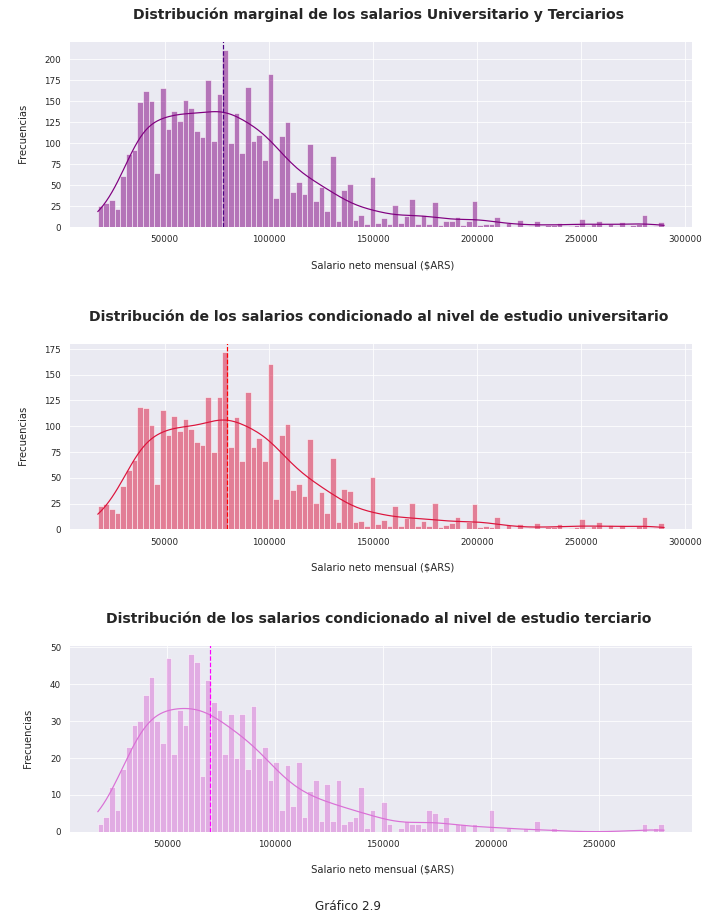

In [23]:
fig, axes = plt.subplots(figsize=(10, 13), nrows=3)

seaborn.histplot(
    df_UT['salary_monthly_NETO'],
    ax=axes[0],
    color="purple",
    kde=True,
    bins=100
).axvline(
    df_UT['salary_monthly_NETO'].median(), 
    color='indigo', 
    linestyle='--'
)
axes[0].set_title("Distribución marginal de los salarios Universitario y Terciarios \n", fontsize=14, weight='bold')
axes[0].set_xlabel("\n Salario neto mensual ($ARS)", fontsize=10)
axes[0].set_ylabel("\n Frecuencias \n", fontsize=10)

seaborn.histplot(
    df_U['salary_monthly_NETO'],
    ax=axes[1],
    color="crimson",
    kde=True,
    bins=100
).axvline(
    df_U['salary_monthly_NETO'].median(), 
    color='red', 
    linestyle='--'
)
axes[1].set_title("Distribución de los salarios condicionado al nivel de estudio universitario \n", fontsize=14, weight='bold')
axes[1].set_xlabel("\n Salario neto mensual ($ARS)", fontsize=10)
axes[1].set_ylabel("\n Frecuencias \n", fontsize=10)

seaborn.histplot(
    df_T['salary_monthly_NETO'],
    ax=axes[2],
    color="orchid",
    kde=True,
    bins=100
).axvline(
    df_T['salary_monthly_NETO'].median(), 
    color='fuchsia', 
    linestyle='--'
)
axes[2].set_title("Distribución de los salarios condicionado al nivel de estudio terciario \n", fontsize=14, weight='bold')
axes[2].set_xlabel("\n Salario neto mensual ($ARS)", fontsize=10)
axes[2].set_ylabel("\n Frecuencias \n", fontsize=10)

plt.annotate(
    'Gráfico 2.9', 
    xy=(0.5, -0.4), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)

fig.tight_layout(h_pad=4)


**Observaciones:**

- Vemos que hay una asociación entre el salario neto y el nivel de estudio. Se puede observar gráficamente que $f_{X|Y}(x|y) \neq f_X(x)$.

- En particular, el histograma de la distribución de salarios netos condicionados a estudios universitarios, tiene una media superior a la distribución de salarios condicionada a estudios terciarios; siendo ambas diferentes a la distribución de frecuencia marginal de los salarios (sin condicionar por nivel de estudios).


**Conclusión:**

- Podemos decir viendo los gráficos que estas variables no parecen ser independientes estadísticamente, sino que tendrían un grado de asociación.

- vemos las métricas para contar con mayor rigurosidad:



### Métricas



**Medidas de centralización**

In [24]:
# Media
print("Media salarial conjunta: {:.2f}".format(df_UT['salary_monthly_NETO'].mean()))
print("Media salarial universitarios: {:.2f}".format(df_U['salary_monthly_NETO'].mean()))
print("Media salarial terciarios:  {:.2f}".format(df_T['salary_monthly_NETO'].mean()))

Media salarial conjunta: 84839.21
Media salarial universitarios: 87046.78
Media salarial terciarios:  76933.36


Con estos valores corroboramos lo que veíamos aproximadamente en el gráfico. La población de universitarios tiene una media salarial mayor a la población de terciarios, siendo ambas distribuciones diferentes a la distribución marginal (que se ubica en el medio de ambas).

In [25]:
# Mediana
print("Mediana salarial conjunta: {:.2f}".format(df_UT['salary_monthly_NETO'].median()))
print("Mediana salarial universitarios: {:.2f}".format(df_U['salary_monthly_NETO'].median()))
print("Mediana salarial terciarios:  {:.2f}".format(df_T['salary_monthly_NETO'].median()))

Mediana salarial conjunta: 78000.00
Mediana salarial universitarios: 80000.00
Mediana salarial terciarios:  70000.00


La mediana, otra medida de posición central pero que no se ve influenciada por los valores extremos de la distribución,  nos brinda más indicios de lo que vimos en los gráficos (2.9) en cuanto a la relación entre las variables salario y nivel de estudio. Los que tienen estudios universitarios tienen mayor mediana que los que tienen estudios terciarios.

In [26]:
# Moda
print("Moda conjunta: {:.2f}".format(df_UT['salary_monthly_NETO'].mode().iat[0]))
print("Moda universitarios: {:.2f}".format(df_U['salary_monthly_NETO'].mode().iat[0]))
print("Moda terciarios: {:.2f}".format(df_T['salary_monthly_NETO'].mode().iat[0]))

Moda conjunta: 80000.00
Moda universitarios: 80000.00
Moda terciarios: 80000.00


La moda es una medida de centralización de los datos, pero que se usa fundamentalmente para variables con "escala de medición categórica", ya que su obtención no necesita más cálculos que observar la categoría o valor con mayor frecuencia (incluso puede haber más de una categoría o valor con frecuencia máxima igual, y en tal caso se trataría por ejemplo, de una distribución "bimodal").

Teniendo en cuenta esto, la moda brinda poca información cuando se está trabajando con variables numéricas, y sobretodo para el caso de las continuas, si se calcula dicha moda sin realizar previamente una sectorización de la misma por intervalos. 

Ahora si, considerando esta información, es que se puede entender que el resultado obtenido con python para la moda de nuestros tres grupos, resulte igual (= $80.000); cuando en realidad estamos viendo al mismo tiempo que difieren en sus medias y medianas.

**Medidas de Dispersión**

In [27]:
# Varianza
print("Varianza conjunta: {:.2f}".format(df_UT['salary_monthly_NETO'].var()))
print("Varianza universitarios: {:.2f}".format(df_U['salary_monthly_NETO'].var()))
print("Varianza terciarios: {:.2f}".format(df_T['salary_monthly_NETO'].var()))

Varianza conjunta: 1927656832.53
Varianza universitarios: 2019087261.52
Varianza terciarios: 1521827653.42


In [28]:
# Desviación estándar
print("Desviación estándar conjunta: {:.2f}".format(df_UT['salary_monthly_NETO'].std()))
print("Desviación estándar universitarios: {:.2f}".format(df_U['salary_monthly_NETO'].std()))
print("Desviación estándar terciarios: {:.2f}".format(df_T['salary_monthly_NETO'].std()))

Desviación estándar conjunta: 43905.09
Desviación estándar universitarios: 44934.25
Desviación estándar terciarios: 39010.61


In [29]:
# Coeficiente de variación
print("Coeficiente de variación conjunta: {:.3f}".format(scipy.stats.variation(df_UT['salary_monthly_NETO'])))
print("Coeficiente de variación universitarios: {:.3f}".format(scipy.stats.variation(df_U['salary_monthly_NETO'])))
print("Coeficiente de variación terciarios: {:.3f}".format(scipy.stats.variation(df_T['salary_monthly_NETO'])))

Coeficiente de variación conjunta: 0.517
Coeficiente de variación universitarios: 0.516
Coeficiente de variación terciarios: 0.507


Al observar la desviación estándar (brinda la misma información que la varianza, sólo que la preferimos para analizar ya que está en la misma unidad de medida que la variable = $), podemos ver que hay una variación importante en los datos de los salarios de las poblaciones.

Para ser más específicos, y su vez poder comparar entre dichas poblaciones, lo que corresponde mirar es el coeficiente de variación, ya que considera la relación que existe entre la desviación estándar, y la media de los datos analizados.

En función de lo que obtuvimos, podemos decir que si bien estos son muy similares, la población de universitarios es levemente más dispersa respecto a su media, que la población de terciarios.

**Medidas de forma**

Si bien no fueron solicitados de forma explícita, estas medidas complementan a las de centralización y dispersión para caracterizar los datos:

In [30]:
# Coeficiente de asimetría
print("Coeficiente de asimetría conjunta: {:.2f}".format(df_UT['salary_monthly_NETO'].skew()))
print("Coeficiente de asimetría universitarios: {:.2f}".format(df_U['salary_monthly_NETO'].skew()))
print("Coeficiente de asimetría terciarios: {:.2f}".format(df_T['salary_monthly_NETO'].skew()))

Coeficiente de asimetría conjunta: 1.55
Coeficiente de asimetría universitarios: 1.53
Coeficiente de asimetría terciarios: 1.59


Los coeficientes de asimetría obtenidos, al ser positivos, muestran que las distribucionse son asimétricas por derecha, siendo la de terciarios la más asimétrica.

In [31]:
# Curtosis
print("Curtosis conjunta: {:.2f}".format(df_UT['salary_monthly_NETO'].kurt()))
print("Curtosis universitarios: {:.2f}".format(df_U['salary_monthly_NETO'].kurt()))
print("Curtosis terciarios: {:.2f}".format(df_T['salary_monthly_NETO'].kurt()))

Curtosis conjunta: 3.54
Curtosis universitarios: 3.40
Curtosis terciarios: 3.82


Al obtener valores de curtosis mayores a tres, decimos que las mismas son leptocúrticas (más puntiagudas o concentradas en ciertos valores, que lo que mostraría una curva normal).

## d) Densidad Conjunta condicional

**Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)**


### Analizamos dos variables numéricas (salario neto y años de experiencia) junto con una categórica (salario dolarizado)


`salary_monthly_NETO` vs `profile_years_experience` vs `salary_is_usd_cat`.

- Para observar dos variables numéricas gráficamente utilizamos el scatterplot.

- Este gráfico muestra en el eje cartesiano todas las observaciones, ubicadas de acuerdo a sus coordenadas (x=salario neto, y=años experiencia); y en este caso puntual en el que agregamos una categórica, se la representa con el parámetro "hue" que colorea dichas observaciones según a qué categoría de aquella pertenezcan.

- De acuerdo a las variables escogidas, lo que esperamos observar es que el salario aumente (tenga posiblemente una relación lineal directa) a medida que aumentan los años de experiencia, y que a su vez haya una diferenciación marcada entre las observaciones de sueldos en pesos respecto a las que están en dólares (estas últimas serían en general mayores que las primeras).


Decidimos usar el gráfico "regplot", que permite graficar la linea de regresión lineal, lo cual nos permite obtener conclusiones más acabadas.

Text(0.5, -0.15, 'Gráfico 2.10')

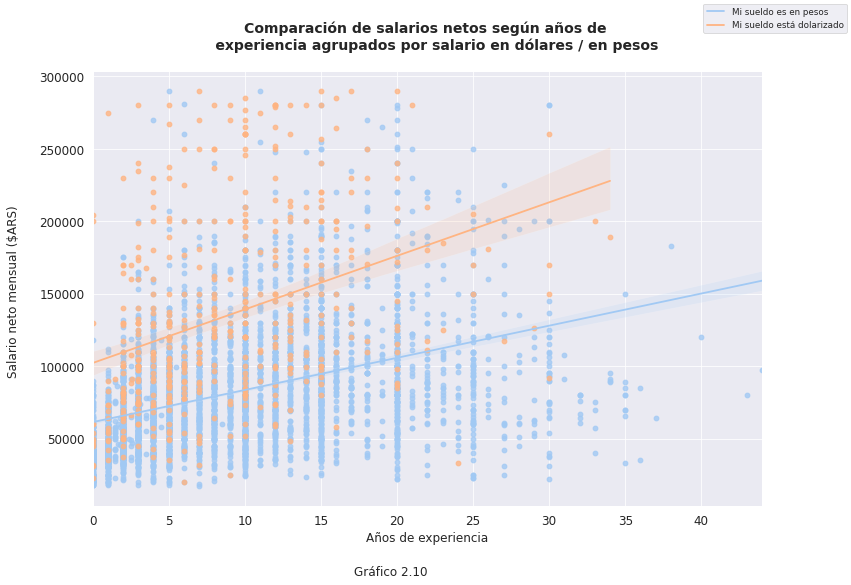

In [32]:
pesos = 'Mi sueldo es en pesos'
dolar = 'Mi sueldo está dolarizado'

fig, axes = plt.subplots(figsize=(12, 8))
seaborn.regplot(
    data=df.query(
        'profile_years_experience < 90 & salary_is_usd_cat == @pesos'
    ),
    y='salary_monthly_NETO', 
    x='profile_years_experience',
)
seaborn.regplot(
    data=df.query(
        'profile_years_experience < 90 & salary_is_usd_cat == @dolar'
    ),
    y='salary_monthly_NETO', 
    x='profile_years_experience'
)

fig.legend(labels=[pesos, dolar])
plt.xlabel("Años de experiencia")
plt.ylabel("Salario neto mensual ($ARS) \n ")
plt.title("Comparación de salarios netos según años de \n \
    experiencia agrupados por salario en dólares / en pesos \n", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.annotate(
    'Gráfico 2.10', 
    xy=(0.5, -0.15), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)


**Observaciones:**

- Como se visualiza en el gráfico 2.10, las líneas de tendencia estimadas para ambos grupos de observaciones (en pesos y en dólares) muestran una relación positiva entre años de experiencia y salario (tal como esperábamos).

- Además, también se visualiza en el gráfico 2.10 que para todos los valores de años de experiencia, los salarios netos mensuales en pesos de los sueldos dolarizados, son mayores a los de los sueldos cobrados efectivamente en pesos.

- Por último, podemos decir que también se observa una mayor pendiente en el caso del grupo "mi sueldo está dolarizado" respecto al de en pesos, implicando que cada aumento unitario de años de experiencia, tiene un retorno mayor en salario para los primeros que para los segundos. También se observa que los dolarizados muestran mayor variabilidad en la estimación de la recta.

Es interesante observar las mismas variables con el gráfico  2.11 jointplot (debajo) , que representa la distribución conjunta de salario y años de experiencia, y sus marginales; todas diferenciadas por los valores de la variables categórica `salary_is_usd_cat`.


- Como es lógico, las conclusiones son coherentes a las obtenidas con el scatterplot: se ve una relación directa entre años y salarios, con mayor pendiente para el grupo de dolarizados respecto a los que están en pesos.

- Además, se agregan a los costados las distribuciones  de los salarios condicionadas a los dos niveles de la variable categórica sueldo dolarizado o no, en donde puede apreciarse el impacto de la poca cantidad de casos de sueldos dolarizados en el total de casos (ver las  distribuciones naranjas -en USD- cómo quedan bajitas en términos de frecuencias al compararlas con las distribuciones azules -en pesos- tanto para años de experiencia, como para la variable salario neto).



Text(-2.5, -0.2, 'Gráfico 2.11')

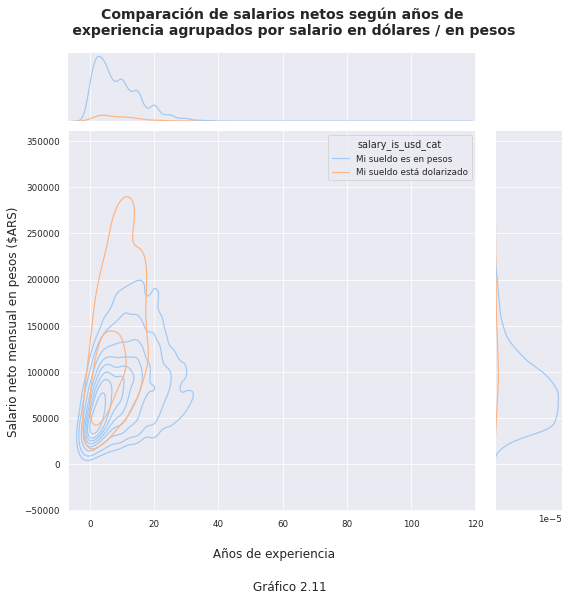

In [33]:
p = seaborn.jointplot(data=df, x='profile_years_experience',
                  y='salary_monthly_NETO', hue='salary_is_usd_cat',
                  kind='kde', height=8)
p.ax_joint.set_xlabel('\n Años de experiencia')
p.ax_joint.set_ylabel('Salario neto mensual en pesos ($ARS)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
p.fig.suptitle("Comparación de salarios netos según años de \n \
    experiencia agrupados por salario en dólares / en pesos \n", fontsize=14, weight='bold')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.9) # Reduce plot to make room 
plt.annotate(
    'Gráfico 2.11', 
    xy=(-2.5, -0.2), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)

--------------------
# FIN
